# Data Analysis

Data analysis often includes activities that look for patterns or signals in the data.  Advanced techniques, such as data modeling and machine learning are outside the scope of the course (but not the ADDM!).  The analysis we cover are basic statistical methods.  We will cover two classes of statistics:

**Descriptive Statistics**
- Describe the data and characteristics of the data
- Examples: mean, standard deviation

**Inferential Statistics**
- Makes inferences from the data to more general conditions (e.g. population)
- Examples: hypothesis testing, point estimation


## But first, let's discuss the data used in the notebook...

The data we are using is provided by the authors of Data Wrangling with Python [\*] It is [UNICEF data](https://github.com/jackiekazil/data-wrangling/tree/master/data/unicef) published from their corpus on child labor. UNICEF has significant data sets on women and children.  This is data from Zimbabwe’s latest Multiple Indicator Cluster Survey.  This is data from survey participants that identify as men.

[\*] Jacqueline Kazil and Katharine Jarmul. 2016. Data Wrangling with Python: Tips and Tools to Make Your Life Easier (1st. ed.). O'Reilly Media, Inc.

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats  ## THIS ONE IS NEW!! SCIPY, NUMPY's scientific analysis cousin

In [ ]:
df_mn = pd.read_csv('files/mn-combined.csv', low_memory=False)
df_mn

The column names are useless.  The data curator did this keep them easy to use in code.  This resulted in the obscure names.  A translation between cryptic column name and a description is provided in `files/mn_headers_updated.csv`.

## Confidence Intervals and Z-Score

Let's go over some basic statistical analysis vocabulary. 

**Point Estimates** 
- Estimate the value of a variable for a population based on an inference about that population
- Example we’ll use: estimate the number of children a person has based on the average number of children in the population
- Based on a sample, estimates likely to vary

**Estimation as an interval**
- Confidence Interval: A range of values such that for the desired level there is confidence in the true value falling within
- Confidence Level: Probability of the true value being included in the interval
- Confidence Limits: Extremes of the confidence interval, the end points

Let's dig in to the data. First, let's group by the `MWAGE` column which is the column of the survey respondent's age and then look at the means for `MCM10`, number of children ever born.

In [ ]:
# let's generate some simple statistics
df_mn.groupby(df_mn['MWAGE'])['MCM10'].describe()

### What kind of observations or data stories are provided in these descriptive statistics?

Can we say something about average number of children men father?  
Are there outliers?

In [ ]:
# These max values are really large, perhaps we have some outliers?
df_mn['MCM10'].describe()

## Central Limit Theorem

Let's nerd out for a moment and talk about some statistical theory...

"In probability theory, the central limit theorem establishes that, in some situations, when independent random variables are added, their properly normalized sum tends toward a normal distribution even if the original variables themselves are not normally distributed." [From Wikipedia](https://en.wikipedia.org/wiki/Central_limit_theorem)

## Z-scores, and the hunt for outliers

The Z-score is the location of each sample value (X) within a distribution.

It is a number that establishes the relationship between:
- The sample value
- The mean
- The standard deviation

The number is a numerical value that specifies the distance from the mean by counting the number of standard deviations. +/- indicates direction.

Consider the following normal distribution:

<div>
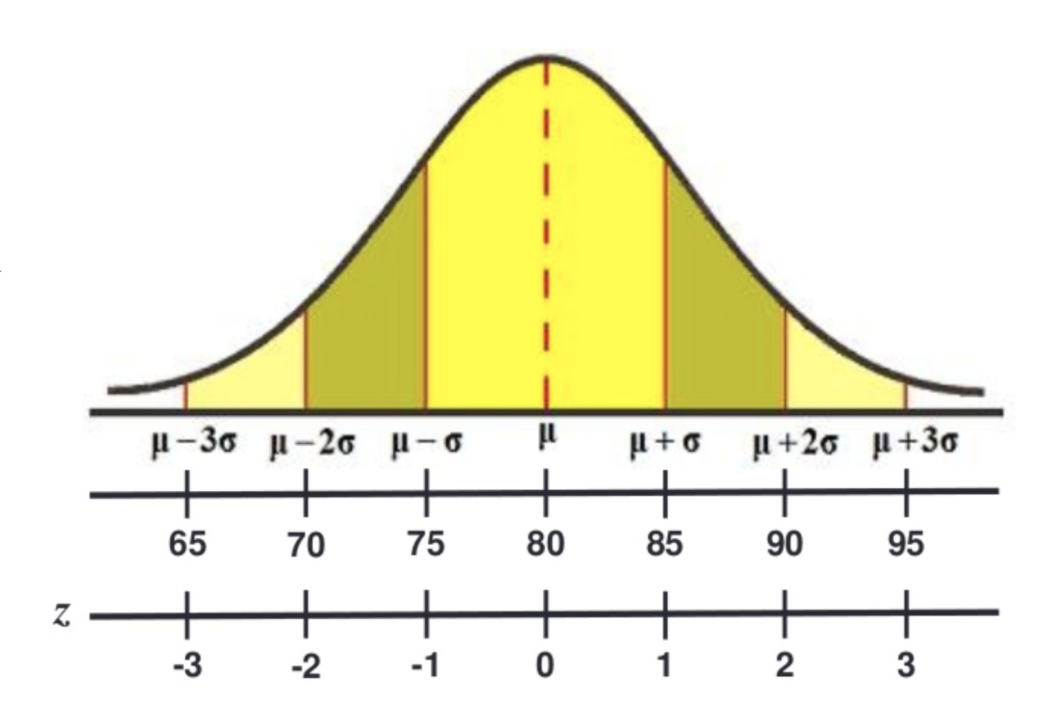
</div>

In the above distribution we can consider cases of X and the resulting Z-score...

|X|Z-score|
|---|----|
|90|2|
|75|-1|

**What is a Z-score good for?**
- Determine where on a distribution a particular score is located
- Standardized entire distributions, making them comparable
- Detecting outliers
    - Mathematically distinguish scores that are very far from the typical response
    - Systematic, adopted approach to ignoring problematic data


Now let's use python and pandas to calculate the Z-scores for the `MCM10` column (number of children ever born). We're going to slightly modify our calculation to only consider *survey respondents that have children*.  We will do this by creating a mask of `MCM10` values above 0.

In [ ]:
mcm11bZS = stats.zscore(df_mn[df_mn['MCM10'] > 0]['MCM10'])
mcm11bZS

Now to make it easier, convert all values to positive scores using `np.abs()` function.

In [ ]:
abs_mcm11bZS = np.abs(mcm11bZS)
abs_mcm11bZS

Now the fun sauce... let's create mask for ***only*** values that are below a Z-score of 3.

In [ ]:
filtered_mcm11bZS = (abs_mcm11bZS < 3)
filtered_mcm11bZS

In [ ]:
#A9
new_df = df_mn[df_mn['MCM10'] > 0]
new_df = new_df[filtered_mcm11bZS]
new_df

OK... now let's use this DataFrame, which contains on the rows for survey participants that have children and ***are not*** outliers.

In [ ]:
new_df.groupby(new_df['MWAGE'])['MCM10'].describe()

Alright... now let's get back to understanding and calculating **confidence intervals**.  Below we're going to calculate the 95% confidence interval for number of children ever born using the above DataFrame (outliers removed) for survey respondents between age 40-44.  Essentially, we are trying to determine the following plain language question:  "For respondents age 40-44, what is the range of number of children that will capture 95% of the sample."  In other words, if we were wanting to pick a range to feel 95% confident when guessing number of children from the age group, what would that range be?

In [ ]:
a40_44 = new_df[new_df['MWAGE'] == '40-44']['MCM10'].dropna().values
a40_44

In [ ]:
stats.t.interval(0.95, len(a40_44)-1, loc=np.mean(a40_44), scale=stats.sem(a40_44))

In [ ]:
a40_44.mean()

The above tells us that the average number of children ever born to those survey respondents age 40-45 is 4.01, with a 95% confidence interval of 3.88 to 4.13.  Simply, 4 children is a solid bet for this population.

## Student's T-test

T-tests are common in Hypothesis Testing & Inferential Statistics

"The t-test is any statistical hypothesis test in which the test statistic follows a Student's t-distribution under the null hypothesis. A t-test is most commonly applied when the test statistic would follow a normal distribution if the value of a scaling term in the test statistic were known." [From Wikipedia](https://en.wikipedia.org/wiki/Student%27s_t-test)

It has wicked cool origins.  Invented by chemist Willam Gosset in Dublin (while working at Guinness brewery).

<div>
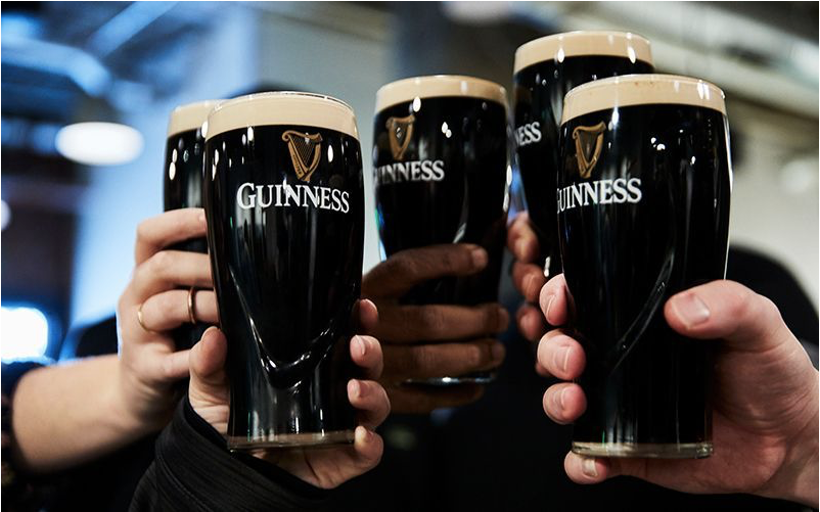
</div>

**Types of Student t:**
- Single sample t
    - One sample, compared with known population mean
    - Answers: Is our sample different from population?

- Independent Samples t
    - Different (independent) samples of participants experience each level of IV
    - Are our samples from different populations?

- Paired/Dependent Samples
    - Same or related (dependent) samples of participants experience each level of IV
    - Are our samples from different populations?

**What is this null hypothesis thing?**

*The hypothesis that there is no significant difference between specified populations, any observed difference being due to sampling or experimental error.*

When we "reject the null hypothesis" we are saying the differences are NOT due to chance and that there is statistical significance between populations.

<div>
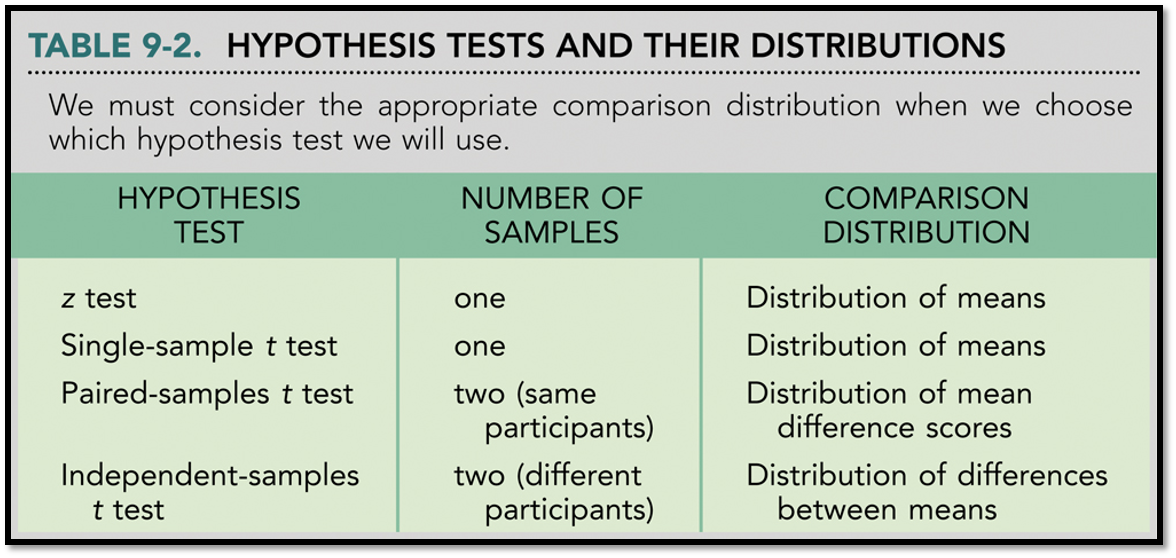
</div>

Let's go back and look at the UNICEF DataFrame, particularly the column `MMSTATUS` which is a column that describes marital status.

In [ ]:
df_mn['MMSTATUS']

In [ ]:
df_mn['MMSTATUS'].describe()

For this to work right, we need to make the type of date in the column categorical data:

In [ ]:
df_mn['MMSTATUS'] = df_mn['MMSTATUS'].astype('category')

Let's look at another column, `MSB15`, which contains data for number of sexual partners in lifetime.

In [ ]:
df_mn['MSB15'].describe()

We can plot this information to visualize the distribution.

In [ ]:
df_mn[['MSB15']].plot(bins=300, kind="hist")

In [ ]:
df_mn['MSB15'].hist(bins=300, cumulative=True)

Let's create two new DataFrames, one that contains survey respondents that are currently married and another the represents those respondents that have never been married.

In [ ]:
married_group = df_mn[df_mn['MMSTATUS'] == 'Currently married/in union']
never_group = df_mn[df_mn['MMSTATUS'] == 'Never married/in union']

In [ ]:
married_group

As we did above, let's remove respondents for which `MSB15` is zero.

In [ ]:
married_group_nonZ = married_group[married_group['MSB15'] > 0]
married_group_nonZ

In [ ]:
never_group_nonZ = never_group[never_group['MSB15'] > 0]
never_group_nonZ

Let's look at the means for these two groups.

In [ ]:
married_group_nonZ['MSB15'].mean()

In [ ]:
never_group_nonZ['MSB15'].mean()

Now we can perform a t-test to determine if these means are statistically significant. Meaning, can we be sure the difference cannot be attributed to chance.

In [ ]:
stats.ttest_ind(married_group_nonZ['MSB15'], never_group_nonZ['MSB15'],equal_var=False)

Indeed, these groups are statistically different.

Let's look at some other columns and do another t-test.  We'll use `MWB4`, highest level of school attended, and `MTA2`, age when cigarette was first smoked for the first time.

In [ ]:
df_mn['MWB4'].unique()

In [ ]:
df_mn['MTA2'].describe()

Yikes, we've got some outliers... let's use our Z-score kung-fu to remove these outliers with statistical conviction!

In [ ]:
mta2_zscore = stats.zscore(df_mn['MTA2'].dropna())
mta2_zscore

In [ ]:
mta2_zscore_abs = np.abs(mta2_zscore)
mta2_zscore_abs

In [ ]:
filter_mta2 = (mta2_zscore_abs < 3)
filter_mta2

In [ ]:
new_df = df_mn.dropna(subset=['MTA2'])
new_df = new_df[filter_mta2]
new_df

Let's use the DataFrame `map()` function to create cleaner columns and also collapse some education categories.

In [ ]:
mapping = {'Higher': 'HSH', 'Secondary': 'HSH', 'Preschool': 'NHS', 'Primary': 'NHS'}
new_df['MWB4-2'] = new_df['MWB4'].map(mapping)
new_df['MWB4-2'].unique()

In [ ]:
new_df['MWB4-2'].describe()

As before, let's separate out data in to two DataFrames for each grouping.

In [ ]:
MWB4_hsh = new_df[new_df['MWB4-2'] == 'HSH']
MWB4_hsh['MWB4-2'].describe()

In [ ]:
MWB4_nhs = new_df[new_df['MWB4-2'] == 'NHS']
MWB4_nhs['MWB4-2'].describe()

OK, now we can look at the means of these two DataFrames

In [ ]:
MWB4_hsh['MTA2'].mean()

In [ ]:
MWB4_nhs['MTA2'].mean()

And, finally, the t-test to see if these populations are different.

In [ ]:
stats.ttest_ind(MWB4_hsh['MTA2'], MWB4_nhs['MTA2'],equal_var=False)

Interesting, the is no statistical difference in age first to smoke a cigarette when compared across education level.  The differences in means is just chance.

## Chi-Squared

Chi-squared allow the classification on one nominal variable to be compared to the classification on a second nominal variable. Example: Are urban American voters more likely to vote democratic than rural American voters?

Statistical focus is on the number of people in the sample classified in patterned ways on two variables. Why? Mean and standard deviations do not make sense for nominal variables.

What is exactly is the statistical test here? Determine whether the pattern or frequencies in the cross classification could have occurred by chance, or whether there is systematic assignment.

Let's go do some more interrogation of this DataFrame.  This time, let's look at `MTA1`, whether a the survey respondent has ever tried smoking -- a categorical representation of the data.

In [ ]:
df_mn['MTA1']

Fit, fit, fitness!  Get it ready!

In [ ]:
df_mn['MTA1'] = df_mn['MTA1'].astype('category')
df_mn['MWAGE'] = df_mn['MWAGE'].astype('category')
df_mn.dropna(subset=['MWAGE', 'MTA1'], inplace=True)
df_mn_new = df_mn[df_mn['MTA1'] != 'Missing']
df_mn_new

We can create a table, called a *crosstab* of two categorical data types.  We will then use this *crosstab* as input into the chi-squared test.

In [ ]:
crosstab = pd.crosstab(df_mn['MWAGE'], df_mn['MTA1'])
crosstab

In [ ]:
stats.chi2_contingency(crosstab)

The above output needs to be parsed.  We want to look at the first three outputs, which are:
- chi2float, The test statistic
- pfloat, The p-value of the test
- dofint, Degrees of freedom

From this output we can see that indeed age has a statistically significant influence on whether a survey respondent has tried smoking.

If we go back to the *crosstab*, we can pull out the pieces to look at the categorical probabilities:

In [ ]:
crosstab

In [ ]:
crosstab['Yes'] / (crosstab['No'] + crosstab['Yes'])